# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 12/10/2024

This notebook will try to perform a point-by-point strain refinement from your tomographic-derived grain shapes.  

### NOTE: It is highly recommended to run this notebook on a Jupyter server with many cores and a lot of RAM.  
The compute_origins() function in particular runs locally and can be compute-intensive for large datasets.  
If this is a big scan (e.g 100 million + 2D peaks), you should definitely refine on the cluster rather than locally.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_file = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to refine
phase_str = 'Si'

# default options for the single-valued map (shouldn't need to modify this)
default_npks = 20
default_nuniq = 20

# refinement tolerances
hkl_tol_origins = 0.05
hkl_tol_refine = 0.1
hkl_tol_refine_merged = 0.05
ds_tol = 0.004
ifrac = 7e-3

# use cluster for refinement or run locally?
use_cluster = False

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [4]:
# Parameters
PYTHONPATH = "../"
dset_file = "tomo_route/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5"
phase_str = "Si"
default_npks = 20
default_nuniq = 20
hkl_tol_origins = 0.05
hkl_tol_refine = 0.1
hkl_tol_refine_merged = 0.05
ds_tol = 0.004
ifrac = 0.007
use_cluster = False


In [5]:
# import functions we need

import os
import concurrent.futures
import timeit

import matplotlib
%matplotlib ipympl

import h5py
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from xfab.symmetry import Umis

import ImageD11.columnfile
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.sinograms.point_by_point import PBPRefine
from ImageD11.peakselect import select_ring_peaks_by_intensity
from ImageD11.sinograms import properties, roi_iradon
from ImageD11.sinograms.sinogram import GrainSinogram, build_slice_arrays, write_slice_recon, read_slice_recon, write_h5, read_h5, write_pbp_strain
from ImageD11.grain import grain
from ImageD11 import cImageD11

import ImageD11.nbGui.nb_utils as utils

In [6]:
# USER: Pass path to dataset file

ds = ImageD11.sinograms.dataset.load(dset_file)
   
sample = ds.sample
dataset = ds.dsname
rawdata_path = ds.dataroot
processed_data_root_dir = ds.analysisroot

print(ds)
print(ds.shape)

dataroot = "/home/esrf/james1997a/Code/ImageD11/test/tomo_route/raw"
analysisroot = "/home/esrf/james1997a/Code/ImageD11/test/tomo_route/processed"
sample = "Si_cube"
dset = "S3DXRD_nt_moves_dty"
shape = ( 41, 3620)
# scans 41 from 1.1 to 41.1
(41, 3620)


In [7]:
# load phases from parameter file

ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Si': <ImageD11.unitcell.unitcell at 0x14c43e2476d0>}

In [8]:
# now let's select a phase to index from our parameters json

ucell = ds.phases.unitcells[phase_str]

print(ucell.lattice_parameters, ucell.spacegroup)

[ 5.43  5.43  5.43 90.   90.   90.  ] 227


In [9]:
# Import 2D peaks

cf_2d = ds.get_cf_2d()
ds.update_colfile_pars(cf_2d, phase_name=phase_str)

print(f"Read {cf_2d.nrows} 2D peaks")

Read 9134 2D peaks


In [10]:
# import grainsinos

grainsinos = read_h5(ds.grainsfile, ds, phase_str)
grains = [gs.grain for gs in grainsinos]

In [11]:
# import slice reconstructions

tensor_map = TensorMap.from_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)

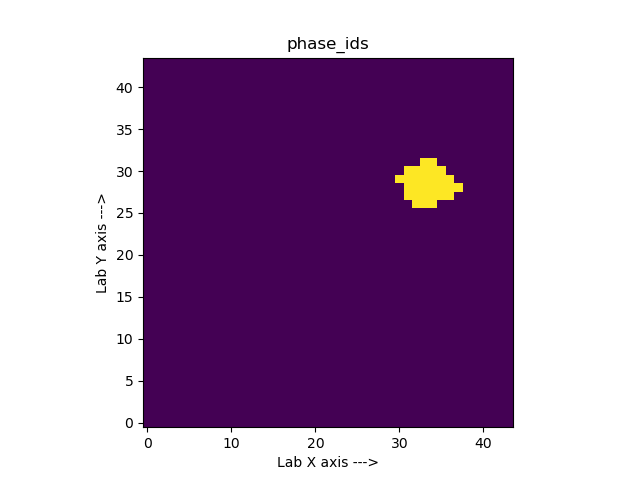

In [12]:
tensor_map.plot('phase_ids')

In [13]:
# make a PBPMap from our TensorMap

pmap = tensor_map.to_pbpmap(z_layer=0, default_npks=default_npks, default_nuniq=default_nuniq)
# fills voxels that have grains with npks = 20 and nuniq = 20

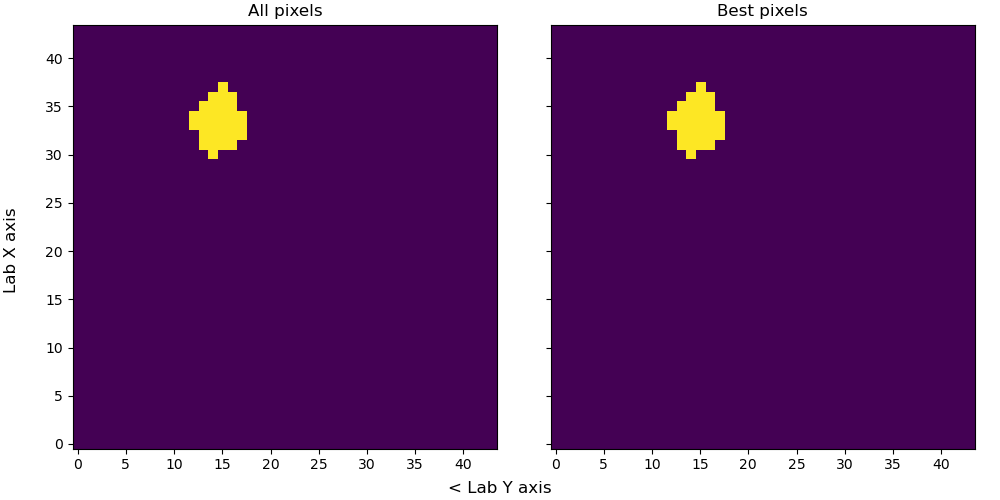

In [14]:
pmap.choose_best(1)
pmap.plot_best(1)

In [15]:
# set up a refinement manager object

y0 = grainsinos[0].recon_y0

refine = PBPRefine(dset=ds, y0=y0, hkl_tol_origins=hkl_tol_origins, hkl_tol_refine=hkl_tol_refine, hkl_tol_refine_merged=hkl_tol_refine_merged, ds_tol=ds_tol, ifrac=ifrac, phase_name=phase_str)

In [16]:
# tell it which point-by-point map we are refining

refine.setmap(pmap)

# or load from disk:
# refine.loadmap()

In [17]:
# set the mask from minimum peak values
# anything greater than 0 should be accepted

refine.mask = pmap.best_npks > 0

In [18]:
# generate a single-valued map to refine on

refine.setsingle(refine.pbpmap, minpeaks=1)

In [19]:
# choose 2D peaks to refine with

refine.setpeaks(cf_2d)

# or load from disk:
# refine.loadpeaks()

refine.icolf.titles

I will delete an existing refined peaks H5 file if I find it on disk!
Waiting 10 seconds for you to interrupt this if you are unhappy


Continuing
To disable this prompt, set prompt_del=False when calling setpeaks()
0 0.3190 (1, 1, 1) 8 74 used, sum_intensity> 18.963
1 0.5209 (2, 2, 0) 12 117 used, sum_intensity> 15.729000000000001
2 0.6108 (3, 1, 1) 24 220 used, sum_intensity> 39.375
4 0.7366 (4, 0, 0) 6 65 used, sum_intensity> 12.159
5 0.8027 (3, 3, 1) 24 223 used, sum_intensity> 7.231
6 0.9022 (2, 2, 4) 24 216 used, sum_intensity> 19.971
7 0.9569 (5, 1, 1) 32 259 used, sum_intensity> 13.139000000000001
8 1.0418 (4, 4, 0) 12 117 used, sum_intensity> 6.58
9 1.0895 (1, 5, 3) 48 437 used, sum_intensity> 7.252
10 1.1050 (2, 4, 4) 24 2 used, sum_intensity> 0.07
11 1.1647 (2, 6, 0) 24 201 used, sum_intensity> 9.723
12 1.2076 (5, 3, 3) 24 173 used, sum_intensity> 4.067
13 1.2216 (2, 6, 2) 24 3 used, sum_intensity> 0.056
14 1.2759 (4, 4, 4) 8 68 used, sum_intensity> 3.0100000000000002
15 1.3152 (7, 1, 1) 48 377 used, sum_intensity> 3.731
16 1.3781 (4, 2, 6) 48 340 used, sum_intensity> 3.297
17 1.4146 (3, 1, 7) 72 463 used, s

['s_raw',
 'f_raw',
 'omega',
 'dty',
 'Number_of_pixels',
 'sum_intensity',
 'spot3d_id',
 'sc',
 'fc',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'ds',
 'gx',
 'gy',
 'gz',
 'isel',
 'dtyi',
 'sinomega',
 'cosomega']

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='d-star', ylabel='sum intensity'>,
        <Axes: xlabel='omega', ylabel='dty'>], dtype=object))

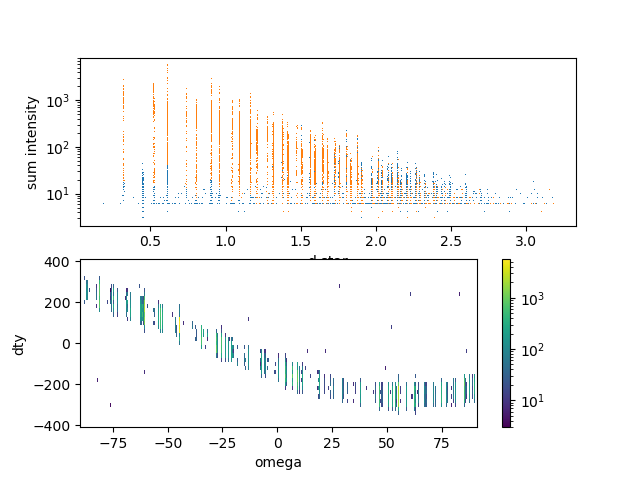

In [20]:
# plot the peaks you selected

refine.iplot()

In [21]:
# compute diffraction origins - these will be added as a column to refine.icolf
# will then save the new column to disk to avoid re-computation

refine.get_origins()

Getting gvecs...
Running test function twice for the first 6088 peaks to guess speed...
This is because we get speed advantages with peaks on consecutive frames
First time to trigger NJIT
Now we time
I estimate roughly 0.0007884147483855486 seconds for all peaks in self.icolf
That's 2.1900409677376348e-07 hours
Lexsort...
Running numba computation on 39 threads, may take a while!
xpos_refined column added to self.icolf
Saving self.icolf to disk with new column


In [22]:
# run the refinement
# if compute_origins took more than a couple of minutes to run, I suggest setting use_cluster=True below
# otherwise if you asked for lots of cores and RAM on this Jupyter instance, you can run it locally (use_cluster=False)

refine.run_refine(use_cluster=use_cluster, pythonpath=PYTHONPATH)

Launching Numba parallel refinement on 39 threads


Saving refined map to disk


In [23]:
# save refinement results to disk

if not use_cluster:
    refine.to_h5()

ds.save()

Saving icolf to disk
Saving input map to disk


Saving output map to disk
Saving myself to disk


In [24]:
# Now that we're happy with our refinement parameters, we can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip in skips_dict

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(ds.dataroot, skips_dict, dset_prefix, sample_list)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_150um"]}
    
# now we have our samples_dict, we can process our data:

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(ds.analysisroot, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        if os.path.exists(ds.refoutfile):
            print(f"Already have PBP refinement output file for {dataset} in sample {sample}, skipping")
            continue
        
        if not os.path.exists(ds.pbpfile):
            print(f"Can't find PBP indexing file for {dataset} in sample {sample}, skipping")
            continue
        
        cf_2d = ds.get_cf_2d()
        ds.update_colfile_pars(cf_2d, phase_name=phase_str)

        if not os.path.exists(ds.col2dfile):
            ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)
            
        grainsinos = read_h5(ds.grainsfile, ds, phase_str)
        y0 = grainsinos[0].recon_y0
        
        tensor_map = TensorMap.from_h5(ds.grainsfile, h5group='TensorMap_' + phase_str)
        pmap = tensor_map.to_pbpmap(z_layer=0, default_npks=default_npks, default_nuniq=default_nuniq)
        pmap.choose_best(1)

        refine = PBPRefine(dset=ds, y0=y0, hkl_tol_origins=hkl_tol_origins, hkl_tol_refine=hkl_tol_refine, hkl_tol_refine_merged=hkl_tol_refine_merged, ds_tol=ds_tol, ifrac=ifrac, phase_name=phase_str)
        
        refine.setmap(pmap)
        refine.setpeaks(cf_2d)
        refine.mask = pmap.best_npks > 0
        refine.setsingle(refine.pbpmap, minpeaks=1)
        refine.get_origins()
        refine.run_refine(use_cluster=use_cluster, pythonpath=PYTHONPATH)
        if not use_cluster:
            # wait to complete locally, then save
            refine.to_h5()
        ds.save()

print("Done!")

Done!
